In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/datasets/Tomato.zip

In [4]:
# initialize the data generator
datagen = ImageDataGenerator(validation_split=0.2)

# get training data
train_ds = datagen.flow_from_directory(
    '/content/Tomato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # set as training data
    seed=42
)

# get validation data
val_ds = datagen.flow_from_directory(
    '/content/Tomato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # set as validation data
    seed=42,
    shuffle=False
)

Found 3601 images belonging to 3 classes.
Found 899 images belonging to 3 classes.


In [5]:
train_ds.class_indices

{'Tomato_Early_blight': 0, 'Tomato_Late_blight': 1, 'Tomato_healthy': 2}

In [6]:
es = EarlyStopping(patience = 5)

model1 = Sequential()

model1.add(layers.Input(shape=(256,256,3)))
model1.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Dense Layers
model1.add(Dense(64, activation='relu'))

# Output
model1.add(Dense(3, activation='softmax'))

model1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [7]:
model1.input_shape

(None, 256, 256, 3)

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [9]:
h = model1.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 27s 134ms/step - loss: 0.9394 - accuracy: 0.6359 - val_loss: 0.5367 - val_accuracy: 0.8220
Epoch 2/20
113/113 [==============================] - 13s 118ms/step - loss: 0.5596 - accuracy: 0.7817 - val_loss: 0.5301 - val_accuracy: 0.7976
Epoch 3/20
113/113 [==============================] - 14s 120ms/step - loss: 0.3590 - accuracy: 0.8642 - val_loss: 0.4523 - val_accuracy: 0.8265
Epoch 4/20
113/113 [==============================] - 15s 134ms/step - loss: 0.2226 - accuracy: 0.9231 - val_loss: 0.2859 - val_accuracy: 0.8843
Epoch 5/20
113/113 [==============================] - 14s 123ms/step - loss: 0.1303 - accuracy: 0.9572 - val_loss: 0.2789 - val_accuracy: 0.8966
Epoch 6/20
113/113 [==============================] - 14s 121ms/step - loss: 0.0834 - accuracy: 0.9717 - val_loss: 0.3014 - val_accuracy: 0.8943
Epoch 7/20
113/113 [==============================] - 14s 121ms/step - loss: 0.0596 - accuracy: 0.9814 - val_loss: 0.3350 - val_ac

Prompted CHAT-GPT 4 to help grab the labels information from the validation dataset and get it into a numpy array, so that we can use that to make a confusion matrix.

In [10]:
def model_preds(model):
  '''
  This function will return the y_true_classes and y_pred_clasess
  Which will allows us to build a confusion matrix
  '''
  
  y_true_classes = val_ds.labels

  y_pred_classes = model.predict(val_ds)

  y_pred_classes = np.argmax(y_pred_classes, axis=1)

  return (y_true_classes, y_pred_classes)

29/29 [==============================] - 3s 102ms/step


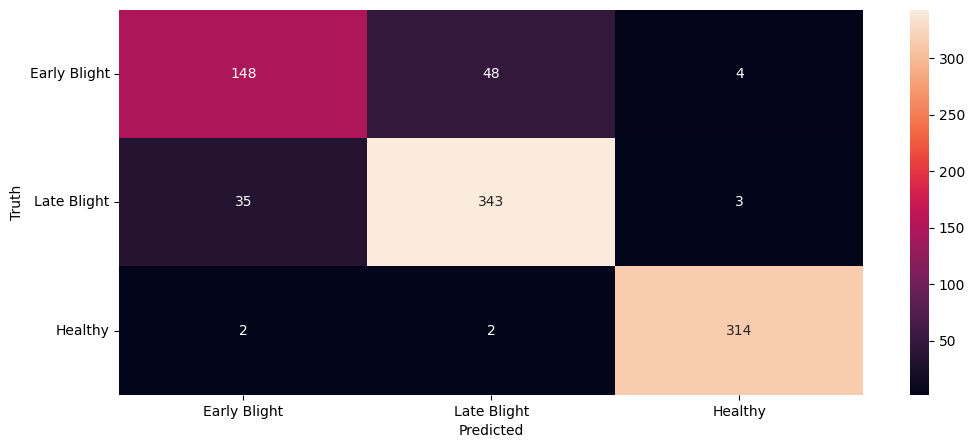

In [11]:
y_true_classes, y_pred_classes = model_preds(model1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [12]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.80      0.74      0.77       200
 Tomato_Late_blight       0.87      0.90      0.89       381
     Tomato_healthy       0.98      0.99      0.98       318

           accuracy                           0.90       899
          macro avg       0.88      0.88      0.88       899
       weighted avg       0.89      0.90      0.89       899



In [13]:
es = EarlyStopping(patience = 5)

model2 = Sequential()

model2.add(layers.Input(shape=(256,256,3)))
model2.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

# Dense Layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))

# Output
model2.add(Dense(3, activation='softmax'))

model2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model2.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 17s 128ms/step - loss: 0.7920 - accuracy: 0.6121 - val_loss: 0.4401 - val_accuracy: 0.7864
Epoch 2/20
113/113 [==============================] - 13s 119ms/step - loss: 0.3533 - accuracy: 0.8514 - val_loss: 0.3182 - val_accuracy: 0.8687
Epoch 3/20
113/113 [==============================] - 14s 120ms/step - loss: 0.2482 - accuracy: 0.8950 - val_loss: 0.2558 - val_accuracy: 0.9021
Epoch 4/20
113/113 [==============================] - 13s 117ms/step - loss: 0.1889 - accuracy: 0.9289 - val_loss: 0.2456 - val_accuracy: 0.8899
Epoch 5/20
113/113 [==============================] - 14s 120ms/step - loss: 0.1135 - accuracy: 0.9575 - val_loss: 0.2264 - val_accuracy: 0.9155
Epoch 6/20
113/113 [==============================] - 14s 122ms/step - loss: 0.0829 - accuracy: 0.9706 - val_loss: 0.3190 - val_accuracy: 0.9021
Epoch 7/20
113/113 [==============================] - 15s 131ms/step - loss: 0.0655 - accuracy: 0.9792 - val_loss: 0.3782 - val_ac

Gets overfit so let's try some regularization.

In [14]:
es = EarlyStopping(patience = 5)

model3 = Sequential()

model3.add(layers.Input(shape=(256,256,3)))
model3.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

# Dense Layers
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

# Output
model3.add(Dense(3, activation='softmax'))

model3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model3.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 122ms/step - loss: 1.1356 - accuracy: 0.4257 - val_loss: 1.0324 - val_accuracy: 0.4238
Epoch 2/20
113/113 [==============================] - 14s 124ms/step - loss: 0.8578 - accuracy: 0.5982 - val_loss: 0.6090 - val_accuracy: 0.7853
Epoch 3/20
113/113 [==============================] - 14s 119ms/step - loss: 0.5083 - accuracy: 0.8095 - val_loss: 0.4910 - val_accuracy: 0.8076
Epoch 4/20
113/113 [==============================] - 13s 119ms/step - loss: 0.3208 - accuracy: 0.8836 - val_loss: 0.3682 - val_accuracy: 0.8509
Epoch 5/20
113/113 [==============================] - 13s 117ms/step - loss: 0.2382 - accuracy: 0.9309 - val_loss: 0.3451 - val_accuracy: 0.8765
Epoch 6/20
113/113 [==============================] - 14s 119ms/step - loss: 0.1331 - accuracy: 0.9603 - val_loss: 0.4254 - val_accuracy: 0.8776
Epoch 7/20
113/113 [==============================] - 14s 128ms/step - loss: 0.1023 - accuracy: 0.9700 - val_loss: 0.4546 - val_ac

Still over fitting a lot, let's add another dropout layer.

In [15]:
es = EarlyStopping(patience = 5)

model4 = Sequential()

model4.add(layers.Input(shape=(256,256,3)))
model4.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())

# Dense Layers
model4.add(Dense(32, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))

# Output
model4.add(Dense(3, activation='softmax'))

model4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model4.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 18s 130ms/step - loss: 1.1227 - accuracy: 0.4768 - val_loss: 0.8662 - val_accuracy: 0.6240
Epoch 2/20
113/113 [==============================] - 15s 136ms/step - loss: 0.8310 - accuracy: 0.6334 - val_loss: 1.0457 - val_accuracy: 0.4316
Epoch 3/20
113/113 [==============================] - 13s 117ms/step - loss: 0.7788 - accuracy: 0.5882 - val_loss: 0.4900 - val_accuracy: 0.7508
Epoch 4/20
113/113 [==============================] - 14s 120ms/step - loss: 0.5399 - accuracy: 0.7559 - val_loss: 0.4008 - val_accuracy: 0.7664
Epoch 5/20
113/113 [==============================] - 14s 123ms/step - loss: 0.4204 - accuracy: 0.8028 - val_loss: 0.3155 - val_accuracy: 0.8665
Epoch 6/20
113/113 [==============================] - 14s 120ms/step - loss: 0.3593 - accuracy: 0.8520 - val_loss: 0.2751 - val_accuracy: 0.8888
Epoch 7/20
113/113 [==============================] - 13s 119ms/step - loss: 0.3064 - accuracy: 0.8692 - val_loss: 0.3369 - val_ac

Still over fitting by a lot. Before trying another dropout layer, let's add in a l2 regularization, and see what the results are.

In [16]:
es = EarlyStopping(patience = 5)

model5 = Sequential()

model5.add(layers.Input(shape=(256,256,3)))
model5.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())

# Dense Layers
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dropout(0.5))
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dropout(0.5))

# Output
model5.add(Dense(3, activation='softmax'))

model5.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model5.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 122ms/step - loss: 1.5523 - accuracy: 0.4729 - val_loss: 1.3139 - val_accuracy: 0.4238
Epoch 2/20
113/113 [==============================] - 13s 118ms/step - loss: 1.0973 - accuracy: 0.6115 - val_loss: 0.7646 - val_accuracy: 0.7497
Epoch 3/20
113/113 [==============================] - 14s 119ms/step - loss: 0.7775 - accuracy: 0.7334 - val_loss: 0.6360 - val_accuracy: 0.7675
Epoch 4/20
113/113 [==============================] - 14s 124ms/step - loss: 0.7379 - accuracy: 0.7395 - val_loss: 0.6074 - val_accuracy: 0.7686
Epoch 5/20
113/113 [==============================] - 14s 120ms/step - loss: 0.6189 - accuracy: 0.7659 - val_loss: 0.5403 - val_accuracy: 0.7709
Epoch 6/20
113/113 [==============================] - 20s 175ms/step - loss: 0.5577 - accuracy: 0.7884 - val_loss: 0.4865 - val_accuracy: 0.8610
Epoch 7/20
113/113 [==============================] - 15s 129ms/step - loss: 0.5462 - accuracy: 0.8153 - val_loss: 0.4707 - val_ac

The model just so happened to start with a really low score, so it was able to hit 20 epochs, but in attempts to reproduce, the model would stil overfit and early stop.

In [17]:
es = EarlyStopping(patience = 5)

model6 = Sequential()

model6.add(layers.Input(shape=(256,256,3)))
model6.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model6.add(Conv2D(64, (3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(64, (3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())

# Dense Layers
model6.add(Dense(16, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dropout(0.5))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dropout(0.5))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))

# Output
model6.add(Dense(3, activation='softmax'))

model6.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model6.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 122ms/step - loss: 1.4344 - accuracy: 0.4654 - val_loss: 1.1137 - val_accuracy: 0.6719
Epoch 2/20
113/113 [==============================] - 13s 119ms/step - loss: 1.0233 - accuracy: 0.6695 - val_loss: 0.8635 - val_accuracy: 0.7264
Epoch 3/20
113/113 [==============================] - 13s 118ms/step - loss: 0.7812 - accuracy: 0.7417 - val_loss: 0.6583 - val_accuracy: 0.7697
Epoch 4/20
113/113 [==============================] - 13s 119ms/step - loss: 0.6669 - accuracy: 0.7537 - val_loss: 0.6123 - val_accuracy: 0.7575
Epoch 5/20
113/113 [==============================] - 13s 119ms/step - loss: 0.5972 - accuracy: 0.7620 - val_loss: 0.5682 - val_accuracy: 0.7642
Epoch 6/20
113/113 [==============================] - 14s 122ms/step - loss: 0.5711 - accuracy: 0.7623 - val_loss: 0.4638 - val_accuracy: 0.8587
Epoch 7/20
113/113 [==============================] - 14s 119ms/step - loss: 0.4926 - accuracy: 0.8528 - val_loss: 0.4626 - val_ac

We've been tackling overfitting, but the accuracy on training is still worse than the validation of the original simple but overfit model. Adding more complexity hasn't really helped us that much. Let's start over, but now mess around with convolutions

In [18]:
es = EarlyStopping(patience = 5)

model7 = Sequential()

model7.add(layers.Input(shape=(256,256,3)))
model7.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model7.add(Conv2D(64, (4,4), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(64, (4,4), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Flatten())

# Dense Layers
model7.add(Dense(64, activation='relu'))

# Output
model7.add(Dense(3, activation='softmax'))

model7.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model7.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 19s 136ms/step - loss: 1.0875 - accuracy: 0.5787 - val_loss: 0.4595 - val_accuracy: 0.8209
Epoch 2/20
113/113 [==============================] - 14s 122ms/step - loss: 0.4872 - accuracy: 0.8045 - val_loss: 0.2902 - val_accuracy: 0.8843
Epoch 3/20
113/113 [==============================] - 14s 124ms/step - loss: 0.2531 - accuracy: 0.9036 - val_loss: 0.3266 - val_accuracy: 0.8632
Epoch 4/20
113/113 [==============================] - 15s 132ms/step - loss: 0.1594 - accuracy: 0.9381 - val_loss: 0.2934 - val_accuracy: 0.8932
Epoch 5/20
113/113 [==============================] - 14s 125ms/step - loss: 0.0795 - accuracy: 0.9761 - val_loss: 0.5039 - val_accuracy: 0.8420
Epoch 6/20
113/113 [==============================] - 14s 127ms/step - loss: 0.0735 - accuracy: 0.9772 - val_loss: 0.3460 - val_accuracy: 0.9055
Epoch 7/20
113/113 [==============================] - 15s 130ms/step - loss: 0.0666 - accuracy: 0.9808 - val_loss: 0.5204 - val_ac

changing the convolution input matrix from 3 x 3 to 4 x 4 didn't have a great effect. Let's go back to 3 x 3 and instead see what happens if we add a conv layer and remove a conv layer.

In [19]:
es = EarlyStopping(patience = 5)

model8 = Sequential()

model8.add(layers.Input(shape=(256,256,3)))
model8.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Flatten())

# Dense Layers
model8.add(Dense(64, activation='relu'))

# Output
model8.add(Dense(3, activation='softmax'))

model8.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model8.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 124ms/step - loss: 0.7082 - accuracy: 0.6673 - val_loss: 0.4071 - val_accuracy: 0.8287
Epoch 2/20
113/113 [==============================] - 14s 120ms/step - loss: 0.3375 - accuracy: 0.8600 - val_loss: 0.3538 - val_accuracy: 0.8598
Epoch 3/20
113/113 [==============================] - 22s 196ms/step - loss: 0.2981 - accuracy: 0.8784 - val_loss: 0.2639 - val_accuracy: 0.8988
Epoch 4/20
113/113 [==============================] - 14s 120ms/step - loss: 0.1958 - accuracy: 0.9284 - val_loss: 0.2283 - val_accuracy: 0.9155
Epoch 5/20
113/113 [==============================] - 14s 121ms/step - loss: 0.1974 - accuracy: 0.9231 - val_loss: 0.1718 - val_accuracy: 0.9355
Epoch 6/20
113/113 [==============================] - 14s 123ms/step - loss: 0.1177 - accuracy: 0.9578 - val_loss: 0.2688 - val_accuracy: 0.9021
Epoch 7/20
113/113 [==============================] - 14s 127ms/step - loss: 0.0901 - accuracy: 0.9656 - val_loss: 0.2070 - val_ac

In [20]:
es = EarlyStopping(patience = 5)

model9 = Sequential()

model9.add(layers.Input(shape=(256,256,3)))
model9.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model9.add(Conv2D(64, (3,3), activation='relu'))
model9.add(MaxPooling2D(pool_size=(2,2)))

model9.add(Flatten())

# Dense Layers
model9.add(Dense(64, activation='relu'))

# Output
model9.add(Dense(3, activation='softmax'))

model9.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model9.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 15s 122ms/step - loss: 3.3388 - accuracy: 0.7651 - val_loss: 0.3054 - val_accuracy: 0.8899
Epoch 2/20
113/113 [==============================] - 13s 117ms/step - loss: 0.1871 - accuracy: 0.9328 - val_loss: 0.2301 - val_accuracy: 0.9132
Epoch 3/20
113/113 [==============================] - 13s 117ms/step - loss: 0.0561 - accuracy: 0.9883 - val_loss: 0.3230 - val_accuracy: 0.8910
Epoch 4/20
113/113 [==============================] - 12s 108ms/step - loss: 0.0331 - accuracy: 0.9917 - val_loss: 0.2416 - val_accuracy: 0.9110
Epoch 5/20
113/113 [==============================] - 13s 113ms/step - loss: 0.0116 - accuracy: 0.9989 - val_loss: 0.2411 - val_accuracy: 0.9232
Epoch 6/20
113/113 [==============================] - 14s 128ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.3687 - val_accuracy: 0.8854
Epoch 7/20
113/113 [==============================] - 14s 120ms/step - loss: 0.0072 - accuracy: 0.9994 - val_loss: 0.3680 - val_ac

Looks like our training accuracy is much more overfit with less validation accuracy. Currently model 8 seems to have the best performance, it has the highest accuracy (~96-99%% on training and ~92-95% on validation accuracy) and is less over fit than other models. Our second best model was model 2 with a train accuracy of ~99% and a validation accuracy of ~92%.

Lets see how well they do with a confusion matrix, because of their similar accuacy scores it is most likely they are going to have similar misclassifiations.
___________________________

## Confusion matrixs

29/29 [==============================] - 2s 77ms/step


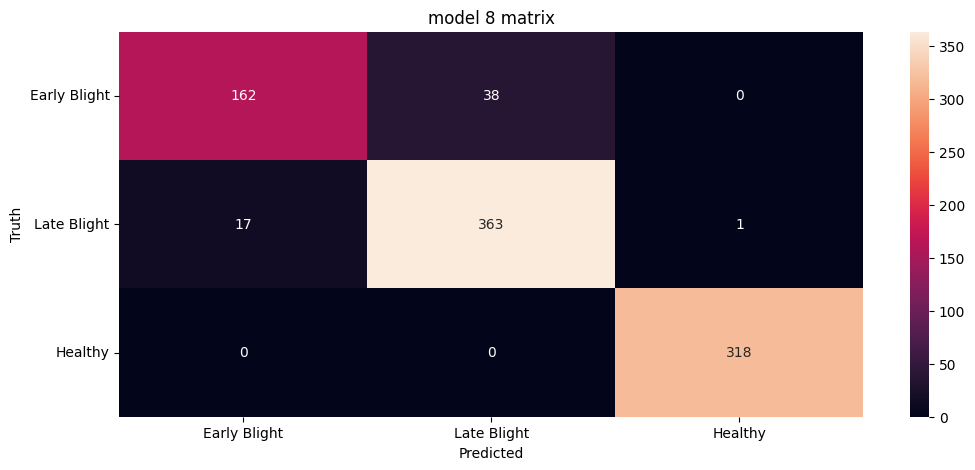

<Figure size 640x480 with 0 Axes>

In [21]:
y_true_classes, y_pred_classes = model_preds(model8)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")
plt.title('model 8 matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
plt.savefig('Model_8_Matrix.png')

In [22]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.91      0.81      0.85       200
 Tomato_Late_blight       0.91      0.95      0.93       381
     Tomato_healthy       1.00      1.00      1.00       318

           accuracy                           0.94       899
          macro avg       0.94      0.92      0.93       899
       weighted avg       0.94      0.94      0.94       899



29/29 [==============================] - 2s 75ms/step


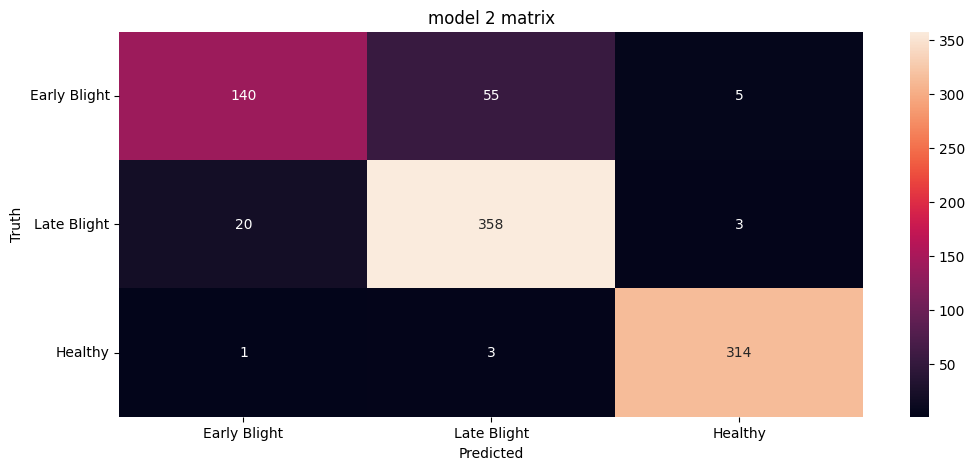

In [23]:
y_true_classes, y_pred_classes = model_preds(model2)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")
plt.title('model 2 matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [24]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.87      0.70      0.78       200
 Tomato_Late_blight       0.86      0.94      0.90       381
     Tomato_healthy       0.98      0.99      0.98       318

           accuracy                           0.90       899
          macro avg       0.90      0.88      0.89       899
       weighted avg       0.90      0.90      0.90       899



As expected since, they have similar accuracy scores we see they have similar classification rates. Lets just check a third model, in this case lets look at our most over fit model, model 9. Which has a training accuracy of 100%, but a validation accuracy of 90%.

29/29 [==============================] - 2s 81ms/step


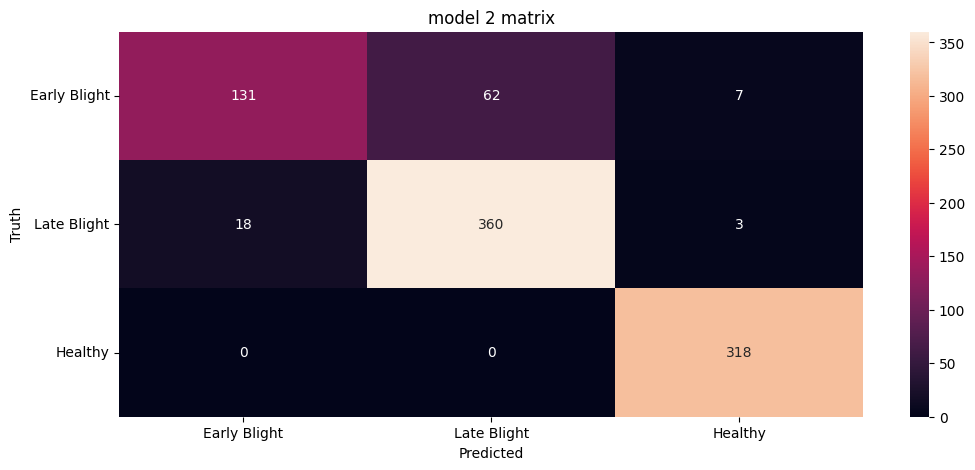

In [25]:
y_true_classes, y_pred_classes = model_preds(model9)
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")
plt.title('model 2 matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [26]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.88      0.66      0.75       200
 Tomato_Late_blight       0.85      0.94      0.90       381
     Tomato_healthy       0.97      1.00      0.98       318

           accuracy                           0.90       899
          macro avg       0.90      0.87      0.88       899
       weighted avg       0.90      0.90      0.90       899



# Conclusion

Model 8 does pretty well on the accuracy score, along with good precision scores.The model can struggle a bit between late blight and early blight, but that is fine because it is very good a distinguishing between healthy and blight as a whole. In the use case of this model, we want a model that can minimizes the number of blighted plants being predicted healthy. The reverse can just cause a waste of time when the user double checks only to find out the plant is heathly. But if a blighted plant passing as a healthy plant can do lots of damage to a crop base as whole. Model 8 does really well in this regard as well, having only 1 misclassified blight case as healthy. 